# 목표
국가 및 출연배우 탐색

In [95]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
# print(matplotlib.__file__)
import subprocess

mpl_file = matplotlib.__file__
mpl_file_loc = '/'.join(mpl_file.split('/')[:-1]) + '/mpl-data/fonts/ttf/'

# 폰트 복사

subprocess.run(f'cp /usr/share/fonts/truetype/nanum/Nanum* {mpl_file_loc}', shell=True)
print(mpl_file_loc)
subprocess.run('rm -rf ~/.cache/matplotlib/*', shell=True)
plt.rcParams["font.family"] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
# 커널 재시작

/mpl-data/fonts/ttf/


In [96]:
class MovieDataLoader:
    def __init__(self, file_path = '../data'):
        self.file_path = file_path
        self.__load_data()

    def __load_data(self):
        for file_name in os.listdir(self.file_path):
            self.file_name = []
            if file_name.endswith('.csv'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name)))
            if file_name.endswith('.txt'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name), sep='\t', engine='python'))



In [97]:
movie_data_loader = MovieDataLoader()
casting = movie_data_loader.castings
countries = movie_data_loader.countries
genres = movie_data_loader.genres
movies = movie_data_loader.movies
peoples = movie_data_loader.peoples
rates = movie_data_loader.rates

In [98]:
movies_rate = movies.merge(rates, on='movie').groupby('movie')['rate'].mean().reset_index()
movies_rate = movies_rate.rename(columns={'rate': 'rate_mean'})
movies_rate.head()

movies_rate_genres = movies_rate.merge(genres, on='movie')
movies_rate_genres.head()



,movie,rate_mean,genre
0,10001,9.294360,드라마
1,10001,9.294360,멜로/로맨스
2,10002,9.416778,SF
3,10002,9.416778,코미디
4,10003,9.270981,SF


In [99]:
# check duplicated genre
genre_info = movies_rate_genres.groupby('movie').size().sort_values(ascending=False)
genre_info.describe()

# we have to handle duplicated genre for each movie
# for correlation calculation, we can use only one genre for each movie

movies_rate_genres_cleaned =  movies_rate_genres.drop_duplicates(subset='movie', ignore_index=True)
movies_rate_genres_cleaned.head()


,movie,rate_mean,genre
0,10001,9.294360,드라마
1,10002,9.416778,SF
2,10003,9.270981,SF
3,10004,9.120000,서부
4,10005,9.048619,판타지


In [100]:
# correlation visualization, as THE PROBLEM REQUIRED BUT IT IS VERY STRANGE
# WHY USE PEARSON CORRELATION? 

# 영화-장르 데이터 피벗
genre_matrix = pd.pivot_table(genres, 
                            index='movie',
                            columns='genre', 
                            aggfunc=lambda x: 1,
                            fill_value=0)

# using cross tab
genre_matrix = pd.crosstab(genres['movie'], genres['genre'])
genre_matrix.head()

genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
movie,,,,,,,,,,,,,,,,,,,,
10001,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10004,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
10005,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


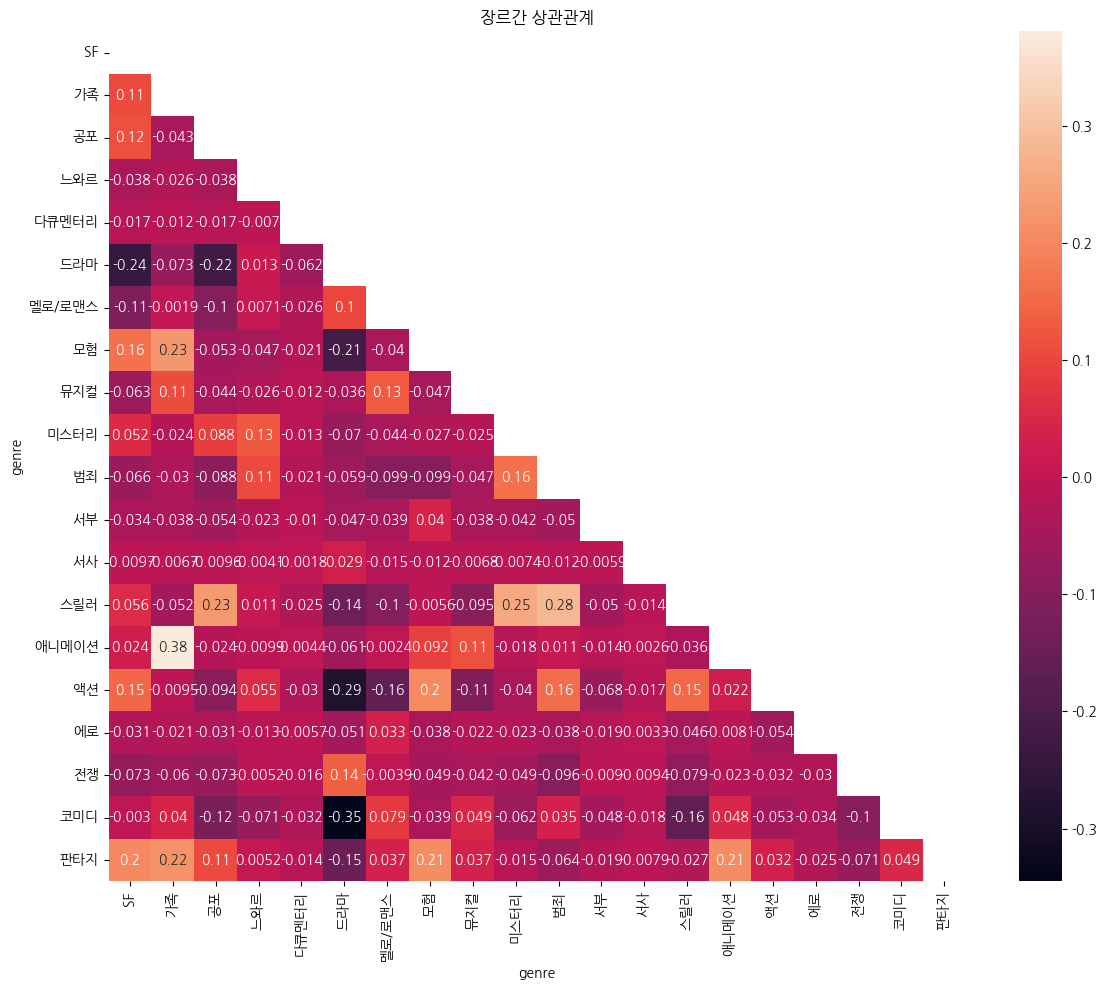

In [101]:
# 장르간 상관계수 계산
genre_corr = genre_matrix.corr('pearson')
genre_corr

mask = np.triu(np.ones_like(genre_corr))
# # # 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(genre_corr, 
            annot=True,
            mask=mask)
plt.title('장르간 상관관계')
plt.tight_layout()
plt.show()


In [102]:
# 애니메이션과 가족이 같이 들어가 있는 데이터
genre_matrix = pd.pivot_table(genres, 
                            index='movie',
                            columns='genre', 
                            aggfunc=lambda x: 1,
                            fill_value=0)

# 애니메이션과 가족이 모두 1인 행 추출
or_condition = genre_matrix[(genre_matrix['애니메이션'] == 1) | (genre_matrix['가족'] == 1)][['애니메이션', '가족']]
or_condition.describe()

# 애니메이션과 가족이 모두 1인 행 추출
and_condition = genre_matrix[(genre_matrix['애니메이션'] == 1) & (genre_matrix['가족'] == 1)][['애니메이션', '가족']]
and_condition.describe()


genre,애니메이션,가족
count,6.0,6.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [103]:
user_genre_ratings = rates.merge(genres, on='movie')
# user_genre_ratings = user_genre_ratings.drop_duplicates(['user', 'movie'])
user_genre_ratings.head()


,user,movie,rate,time,genre
0,0,10003,7,1494128040,SF
1,0,10003,7,1494128040,코미디
2,0,10004,7,1467529800,서부
3,0,10004,7,1467529800,SF
4,0,10004,7,1467529800,판타지


In [104]:
# 사용자-장르 평균 평점 매트릭스 생성, 
# THERE ARE MANY MISSING VALUES, so it's analysis is not valid

user_genre_matrix = user_genre_ratings.pivot_table(
    index='user',
    columns='genre',
    values='rate',
    aggfunc='mean',
    fill_value=0
)

user_genre_matrix


genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
user,,,,,,,,,,,,,,,,,,,,
0,7.818182,7.333333,9.000000,8.5,0.0,7.266667,7.315789,7.000000,6.750000,8.000000,8.285714,6.666667,0.0,8.333333,7.0,7.291667,0.0,7.0,6.933333,6.833333
1,0.000000,0.000000,0.000000,0.0,0.0,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,7.250000,0.000000,7.800000,0.0,0.0,7.571429,9.666667,8.000000,0.000000,0.000000,0.000000,10.000000,0.0,7.333333,0.0,7.250000,0.0,9.0,8.000000,8.500000
3,8.000000,7.000000,8.333333,0.0,0.0,7.410714,7.285714,7.666667,7.666667,8.333333,8.666667,9.500000,0.0,7.611111,0.0,7.533333,3.0,7.0,7.454545,7.600000
4,5.000000,4.500000,7.000000,4.0,0.0,6.906977,7.083333,6.800000,9.000000,6.666667,6.333333,7.000000,0.0,7.000000,2.0,6.181818,0.0,7.8,6.666667,8.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52023,0.000000,0.000000,0.000000,0.0,0.0,10.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,0.0,10.000000,0.0,0.0,0.000000,0.000000
52024,0.000000,0.000000,0.000000,0.0,0.0,10.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,0.0,10.000000,0.0,0.0,0.000000,0.000000
52025,0.000000,0.000000,0.000000,0.0,0.0,7.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.000000,0.0,7.000000,0.0,0.0,0.000000,0.000000


In [105]:
# # 장르간 상관관계 계산
genre_correlations = user_genre_matrix.corr()
genre_correlations



genre,SF,가족,공포,느와르,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
genre,,,,,,,,,,,,,,,,,,,,
SF,1.000000,0.167283,0.262066,0.043353,-0.003874,-0.266573,-0.086301,0.163136,0.003621,0.099983,0.021789,0.137757,0.034479,0.471431,0.119058,0.505782,0.024154,0.065878,0.212407,0.222518
가족,0.167283,1.000000,0.097802,0.070470,-0.002305,-0.121868,0.057283,0.645417,0.173705,0.107437,0.358301,0.103102,0.062088,0.065681,0.351542,0.032279,0.037663,0.085845,0.493339,0.279323
공포,0.262066,0.097802,1.000000,0.111390,-0.002703,-0.085460,0.116254,0.106582,0.053084,0.282556,0.180932,0.119618,0.068832,0.396787,0.060589,0.222254,0.041717,0.119780,0.087555,0.282635
느와르,0.043353,0.070470,0.111390,1.000000,0.011677,0.124882,0.038210,0.064549,0.050073,0.113598,0.337886,0.110992,0.076230,0.071986,0.056303,0.315880,0.042032,0.135930,0.046997,0.092415
다큐멘터리,-0.003874,-0.002305,-0.002703,0.011677,1.000000,0.005307,0.002372,0.004582,-0.002080,-0.001403,0.003693,-0.001234,-0.000882,0.002978,-0.000849,0.001661,-0.000243,-0.001925,0.003666,0.005577
드라마,-0.266573,-0.121868,-0.085460,0.124882,0.005307,1.000000,0.251318,-0.046587,0.182606,0.082032,0.145280,0.059942,0.101607,-0.086091,-0.035816,-0.118135,0.005502,0.209159,-0.163455,-0.104372
멜로/로맨스,-0.086301,0.057283,0.116254,0.038210,0.002372,0.251318,1.000000,0.097283,0.426491,0.071874,0.001896,0.062325,0.023640,-0.070287,0.099587,-0.048336,0.033809,0.146295,0.130192,0.333880
모험,0.163136,0.645417,0.106582,0.064549,0.004582,-0.046587,0.097283,1.000000,0.113029,0.120400,0.307686,0.210131,0.059061,0.087233,0.142219,0.182998,0.033772,0.130003,0.353961,0.356802
뮤지컬,0.003621,0.173705,0.053084,0.050073,-0.002080,0.182606,0.426491,0.113029,1.000000,0.083520,0.027281,0.093233,0.054672,-0.000700,0.216984,-0.042025,0.028321,0.092003,0.113179,0.131286


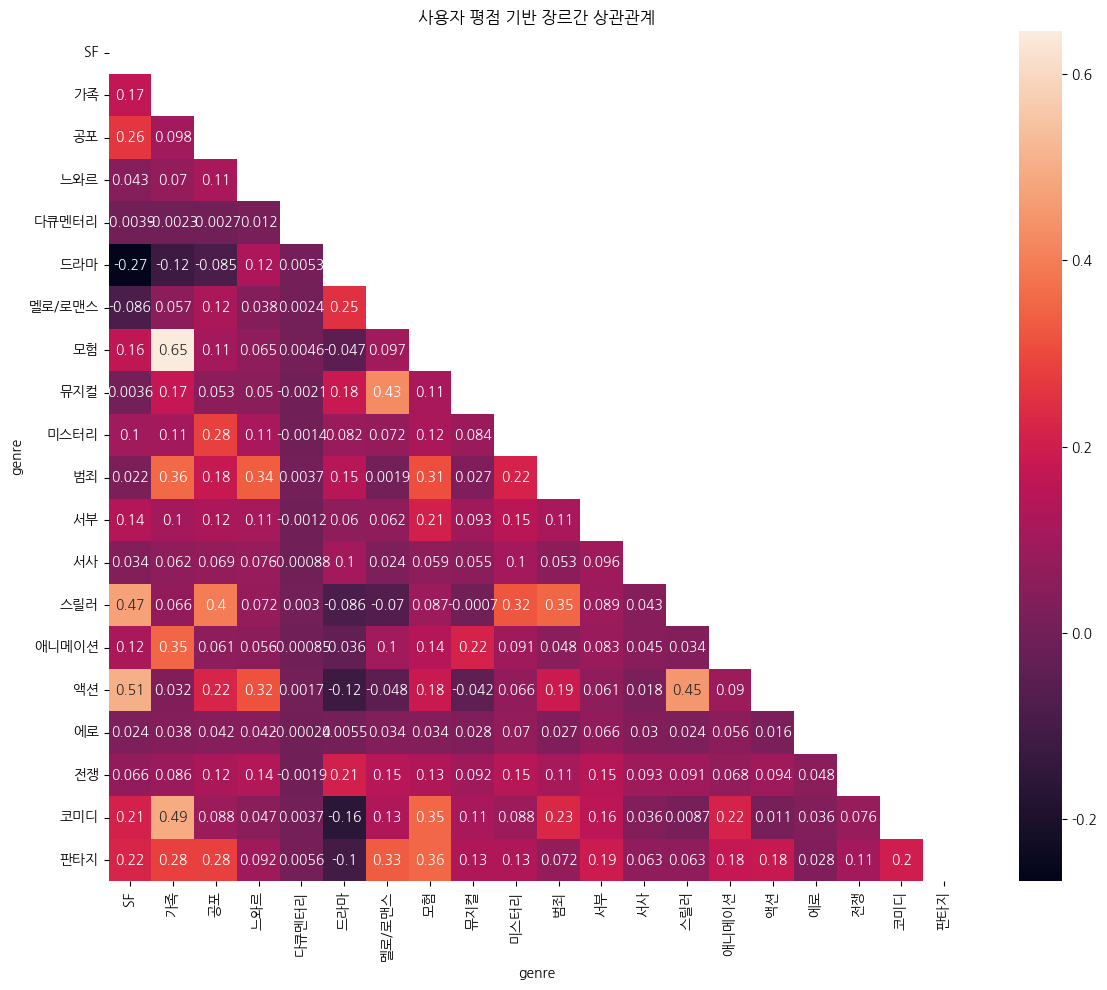

In [106]:
# # 시각화
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(genre_correlations))
sns.heatmap(genre_correlations, 
            annot=True,
            mask=mask)
plt.title('사용자 평점 기반 장르간 상관관계')
plt.tight_layout()
plt.show()


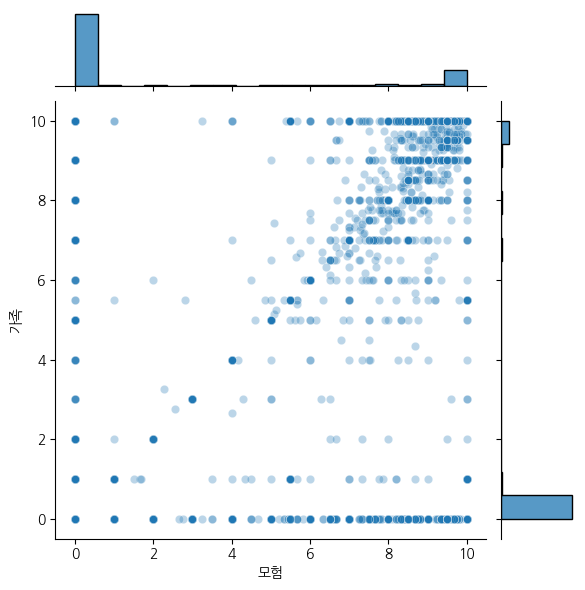

In [113]:

## 모험-가족 장르간 시각화

sns.jointplot(x=user_genre_matrix['모험'], y=user_genre_matrix['가족'], kind='scatter', alpha=0.3)
plt.show()
